## Exercise - Kernel Authoring - Book Histogram - SOLUTION

Let's learn to use some advanced CUDA features like shared memory, atomics, and [cuda.cooperative](https://nvidia.github.io/cccl/python/cooperative.html) to write an efficient histogram kernel to determine the most frequent characters in a collection of books.

First, let's download our dataset.

In [2]:
import os

if os.getenv("COLAB_RELEASE_TAG") and not os.path.exists("/ach-installed"): # If running in Google Colab:
  !curl -s -L -O https://developer.nvidia.com/downloads/assets/tools/secure/nsight-systems/2025_3/NsightSystems-linux-cli-public-2025.3.1.90-3582212.deb
  !sudo dpkg -i NsightSystems-linux-cli-public-2025.3.1.90-3582212.deb > /dev/null
  !pip uninstall "cuda-python" --yes > /dev/null
  !pip install "numba-cuda" "cuda-cccl[test-cu12]" "nsightful[notebook] @ git+https://github.com/brycelelbach/nsightful.git" > /dev/null 2>&1
  open("/ach-installed", "a").close()

import numpy as np
import matplotlib.pyplot as plt
import nsightful
import urllib.request

In [3]:
urllib.request.urlretrieve(
  "https://drive.usercontent.google.com/download?id=1MW1lPgkTq3YG9ikuq6u3d9sfpt-wKQZ0&export=download",
  "books__15m.txt")

('books__15m.txt', <http.client.HTTPMessage at 0x7e5a9ed32e40>)

A histogram kernel counts the number of times a value occurs in a dataset. To implement this, we create an array that is large enough to store all possible values (in the case of counting 1-byte ASCII characters, 256 elements). Then for the value of each element in the dataset, we increment its location in the array.

Let's try a simple way to implement this:

In [4]:
%%writefile histogram_global.py

from numba import cuda
import cupy as cp
import cupyx as cpx
import sys
import os

bins = 256

values = cp.fromfile("books__15m.txt", dtype=cp.uint8)
histogram = cp.zeros((bins), dtype=cp.int32)

threads_per_block = 512 if len(sys.argv) < 3 else int(sys.argv[2])
items_per_thread = 8 if len(sys.argv) < 4 else int(sys.argv[3])
items_per_block = threads_per_block * items_per_thread
blocks = int(len(values) / (threads_per_block * items_per_thread))
assert values.size % items_per_block == 0

@cuda.jit
def histogram_global(values, histogram):
  for i in range(items_per_thread):
    value = values[cuda.grid(1) * items_per_thread + i]
    cuda.atomic.add(histogram, value, 1)

def launch(check, output):
  histogram[:] = 0 # Reset histogram to 0 each trial.
  histogram_global[blocks, threads_per_block](values, histogram)

  if (check):
    assert cp.sum(histogram) == len(values)

  if (output):
    cp.savetxt(sys.stdout, histogram, delimiter=",", fmt="%i")

if len(sys.argv) >= 2 and sys.argv[1] == "output":
  launch(check=True, output=True)
elif os.getenv("NV_COMPUTE_PROFILER_PERFWORKS_DIR"): # Running under `ncu`.
  launch(check=False, output=False) # `ncu` slows things down; so just launch once when running under it.
else:
  launch(check=True, output=False)
  D = cpx.profiler.benchmark(launch, (False, False), n_repeat=15, n_warmup=4).gpu_times[0]
  print(f"{D.mean():.3g} s ± {(D.std() / D.mean()):.2%} (mean ± relative stdev of {D.size} runs)")

Writing histogram_global.py


Now let's make sure it runs and check the output.

In [5]:
!python histogram_global.py

0.00858 s ± 3.22% (mean ± relative stdev of 15 runs)


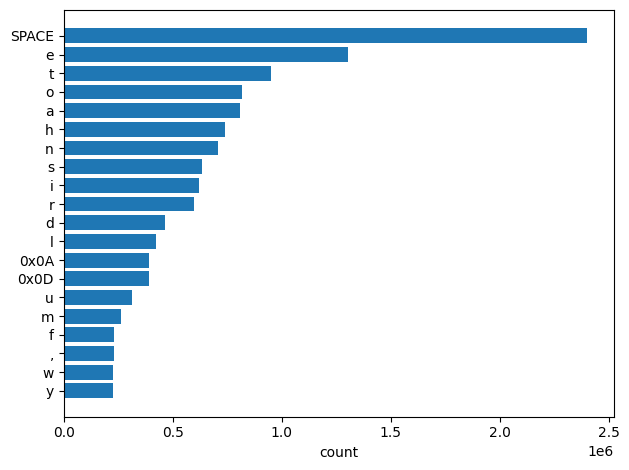

In [6]:
histogram_output = !python histogram_global.py output
histogram = np.loadtxt(histogram_output, delimiter=",")

# Print most frequently occuring characters.
pairs = sorted(((i,c) for i,c in enumerate(histogram) if c), key=lambda x: x[1], reverse=True)[:20]
labels = [('SPACE' if i==32 else chr(i)) if 32<=i<=126 else f'0x{i:02X}' for i,_ in pairs]
plt.barh(labels[::-1], [c for _,c in pairs][::-1]); plt.xlabel('count'); plt.tight_layout(); plt.show()

It looks like something is wrong - our counts are very low, and the most common characters don't make a lot of sense. Many of our increments seem to get lost!

What's happening here is called a data race. Many different threads are trying to access the bins of the histogram at the same time.

Imagine that two threads are trying to update the same bin.

- Thread 0 reads the count of the bin, which is 0, and stores it in its local variable `old_count`.
- Thread 0 adds 1 to its `old_count`, producing a `new_count` of 1.
- Thread 1 reads the count of the bin, which is still 0, and stores it in its local variable `old_count`.
- Thread 1 adds 1 to its `old_count`, producing a `new_count` of 1.
- Thread 0 stores `new_count` to the bin, setting it to 1.
- Thread 1 stores `new_count` to the bin, setting it to 1, and losing the increment from thread 0!

To fix this, we need to use atomic operations. `cuda.atomic.add(array, index, value)` will perform `array[index] += value` as a single indivisible operation. This will ensure that no increments get lost.

Now let's profile our code.

In [7]:
!ncu -f --kernel-name regex:histogram_global --set full -o histogram_global python histogram_global.py
histogram_global_csv = !ncu --import histogram_global.ncu-rep --csv

==PROF== Connected to process 1318 (/usr/bin/python3.12)
==PROF== Profiling "histogram_global[abi:v1,cw51cXTLSUwv1sDUaKthrqNgqqmjgOR3W3Cw6igA9duC0hkwnNGiHEkYkrqQBFBTDEwCyQe21eqwcFW3UoDGjzpQEsgzrtUEAA_3d_3d]": 0%....50%....100% - 30 passes
==PROF== Disconnected from process 1318
==PROF== Report: /content/histogram_global.ncu-rep


In [8]:
nsightful.display_ncu_csv_in_notebook(histogram_global_csv)

<IPython.core.display.Javascript object>

Dropdown(description='Kernel:', layout=Layout(width='400px'), options=('histogram_global',), style=Description…

Output()

We improved the code by separating loading from values from the histogram update and to perform striped loads using [cuda.cooperative](https://nvidia.github.io/cccl/python/cooperative.html)'s block load instead of doing the I/O by hand.

While that helps a bit, our code still has major issues. It's taking thousand of cycles to issue a single operation!

This is happening due to contention - we have hundreds of thousands of threads performing atomic updates to just 256 bins of a global histogram. All of those atomic operations have to happen in order, so they are serialized by the memory subsystem, destroying our parallelism.

Instead, we can construct a local histogram for each block, which we will update atomically within the block. Then, we synchronize all of the threads within the block, and we perform atomic updates of the global histogram with the aggregate counts t

In [9]:
%%writefile histogram_localized.py

from numba import cuda
import cupy as cp
import cupyx as cpx
import cuda.coop as coop
import sys
import os

bins = 256

values = cp.fromfile("books__15m.txt", dtype=cp.uint8)
histogram = cp.zeros((bins), dtype=cp.int32)

threads_per_block = 512 if len(sys.argv) < 3 else int(sys.argv[2])
items_per_thread = 32 if len(sys.argv) < 4 else int(sys.argv[3])
items_per_block = threads_per_block * items_per_thread
blocks = int(len(values) / (threads_per_block * items_per_thread))
assert values.size % items_per_block == 0

block_load = coop.block.load(cp.uint8, threads_per_block, items_per_thread, 'striped')

@cuda.jit(link=block_load.files)
def histogram_localized(values, histogram):
  items = cuda.local.array(items_per_thread, dtype=values.dtype)

  base = cuda.blockIdx.x * items_per_block

  block_load(values[base : base + items_per_block], items)

  local_histogram = cuda.shared.array(bins, dtype=histogram.dtype)

  for i in range(0, bins, threads_per_block):
    bin = i + cuda.threadIdx.x
    if bin < local_histogram.size:
      local_histogram[bin] = 0

  cuda.syncthreads()

  for i in range(items_per_thread):
    cuda.atomic.add(local_histogram, items[i], 1)

  cuda.syncthreads()

  for i in range(0, bins, threads_per_block):
    bin = i + cuda.threadIdx.x
    if bin < histogram.size:
      cuda.atomic.add(histogram, bin, local_histogram[bin])

def launch(check, output):
  histogram[:] = 0 # Reset histogram to 0 each trial.
  histogram_localized[blocks, threads_per_block](values, histogram)

  if (check):
    assert cp.sum(histogram) == len(values)

  if (output):
    cp.savetxt(sys.stdout, histogram, delimiter=",", fmt="%i")

if len(sys.argv) >= 2 and sys.argv[1] == "output":
  launch(check=True, output=True)
elif os.getenv("NV_COMPUTE_PROFILER_PERFWORKS_DIR"): # Running under `ncu`.
  launch(check=False, output=False) # `ncu` slows things down; so just launch once when running under it.
else:
  launch(check=True, output=False)
  D = cpx.profiler.benchmark(launch, (False, False), n_repeat=15, n_warmup=4).gpu_times[0]
  print(f"{D.mean():.3g} s ± {(D.std() / D.mean()):.2%} (mean ± relative stdev of {D.size} runs)")

Writing histogram_localized.py


Let's make sure it runs correctly:

In [10]:
!python histogram_localized.py

0.000714 s ± 2.97% (mean ± relative stdev of 15 runs)


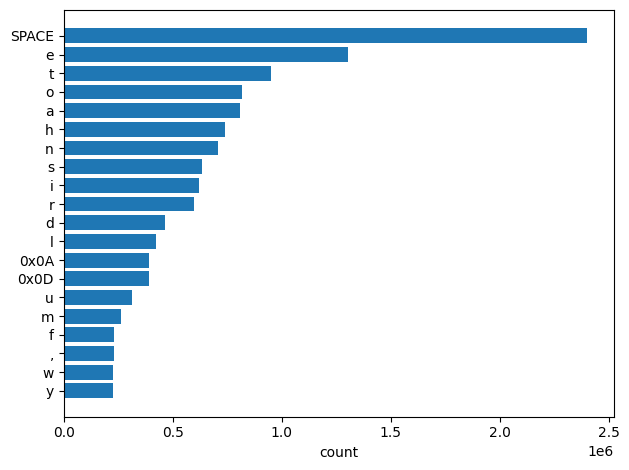

In [11]:
histogram_output = !python histogram_localized.py output
histogram = np.loadtxt(histogram_output, delimiter=",")

# Print most frequently occuring characters.
pairs = sorted(((i,c) for i,c in enumerate(histogram) if c), key=lambda x: x[1], reverse=True)[:20]
labels = [('SPACE' if i==32 else chr(i)) if 32<=i<=126 else f'0x{i:02X}' for i,_ in pairs]
plt.barh(labels[::-1], [c for _,c in pairs][::-1]); plt.xlabel('count'); plt.tight_layout(); plt.show()

Now let's profile it:

In [12]:
!ncu -f --kernel-name regex:histogram_localized --set full -o histogram_localized python histogram_localized.py
histogram_localized_csv = !ncu --import histogram_localized.ncu-rep --csv

==PROF== Connected to process 1492 (/usr/bin/python3.12)
==PROF== Profiling "histogram_localized[abi:v1,cw51cXTLSUwv1sDUaKthrqNgqqmjgOR3W3Cw6igA9duC0hkwnNGiHEkYkrqQBFBTDEwCyQe21eqwcFW3UoDGjzpQEsgzrtUEAA_3d_3d]": 0%....50%....100% - 30 passes
==PROF== Disconnected from process 1492
==PROF== Report: /content/histogram_localized.ncu-rep


In [13]:
nsightful.display_ncu_csv_in_notebook(histogram_localized_csv)

<IPython.core.display.Javascript object>

Dropdown(description='Kernel:', layout=Layout(width='400px'), options=('histogram_localized',), style=Descript…

Output()

Finally, let's benchmark our two approaches.

In [14]:
histogram_global_duration    = !python histogram_global.py
histogram_localized_duration = !python histogram_localized.py
speedup = float(histogram_global_duration[0].split()[0]) / float(histogram_localized_duration[0].split()[0])

print(f"histogram_global:    {histogram_global_duration[0]}")
print(f"histogram_localized: {histogram_localized_duration[0]}")
print(f"histogram_localized speedup over histogram_global: {speedup:.2f}")

histogram_global:    0.00881 s ± 1.13% (mean ± relative stdev of 15 runs)
histogram_localized: 0.000707 s ± 3.10% (mean ± relative stdev of 15 runs)
histogram_localized speedup over histogram_global: 12.46
